This notebook best viewed here: https://nbviewer.jupyter.org

# rewrite

This notebook is for Jack pine GEA mapping pops

1. [Choose SNPs for GEA structure correction in baypass](#choose)
    1. [load snps and filter for depth](#depth)
        - filter for 20≤depth<1000.
    1. [reduce SNPs to those on contigs ≥ 1Kbp](#contig)
    1. [try and filter for no missing data](#missing)
        - I tried this, but I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data, so filters for nomissing data was not implemented
    1. [choose one snp per contig at random](#random)
    1. [determine threshold for LD pruning](#r2thresh)
        - an r2thresh of 0.3757. Using a threshold below this value resulted in non-converging covariance matrix estimation across replicates. This threshold corresponded roughly to the 99.9th percentile of the distribution of LD values.
    1. [LD prune random loci](#prune)
    
    
1. [create infiles to baypass to estimate neutral structure](#infiles)
    1. [genotype file](#genotyping)
    1. [poolsizefile](#poolsizefile)

1. [create 5 replicate estimates of the covariance matrix](#covariance)
    1. [make and rsync shfiles for cedar HPC server](#shfiles)
        - bash shfiles were submitted to slurm for execution

1. [look at covariance matrices output from chains](#look)
    1. [rsync the files from cedar HPC](#rersync)
    1. [read in matrices and look at convergence](#readin)
        - matrices were highly correlated (r > 0.907)
    1. [estimate average covariance matrix](#avg)
    1. [compare avg matrix to replicate matrices](#compare)
        - the avg matrix was highly correlated with each of the replicate matrices (r > 0.964)

1. [create infiles to baypass for GEA](#geainfiles)
    1. [environmental file](#efile)
    1. [genotype file](#gfile)
        1. [break up genotype file for parallelization](#gparallel)

1. [create commands to run baypass GEA using gfiles from above](#commands)
    1. [create catfiles to hold commands](#catfiles)
    1. [create slurm shfiles for executing commands in parallel](#geashfiles)
    1. [transfer to cedar, graham, beluga, and arc](#transfer)
        - bash shfiles were submitted to slurm for execution

In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled'
snpdir = op.join(DIR, 'snpsANDindels/without_p24/03_maf-p05_RD-recalculated')
assert op.exists(snpdir)
baydir = makedir(op.join(snpdir, 'baypass'))
lview,dview = get_client()

56 56


<a id='choose'></a>
# Choose SNPs for GEA structure correction in baypass


[top](#home)

In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit a22cc82763e7d6bc5507200697d8420704934bb7
Author: Brandon <lindb@vcu.edu>
Date:   Thu Jan 28 11:09:19 2021 -0700
Today:	February 11, 2021 - 16:20:43
python version: 3.8.5
##################################################################



In [3]:
# get parallel engines
lview,dview = get_client()

56 56


<a id='depth'></a>
#### load snps and filter for depth
[top](#home)

In [4]:
# figure making functions
def get_mafdict(afs, roundto):
    # bins for maf spectrum
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['filtered snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

# filtering functions
def filter_depth(chunk):
    """Filter min/max depth, reduce columns."""
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['unstitched_chrom', 'unstitched_locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[(chunk[col] >= 20) | (chunk[col].isnull())].copy()
        chunk = chunk[(chunk[col] < 1000) | (chunk[col].isnull())].copy()
    chunk.index = chunk['unstitched_locus'].tolist()
    return chunk

In [5]:
snpdir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated'

In [6]:
# create kwarg to parallel_read()
fundict = create_fundict(filter_depth)
fundict

OrderedDict([('filter_depth',
              {'filter_depth': <function __main__.filter_depth(chunk)>,
               'args': {},
               'kwargs': {}})])

In [7]:
# get the file
snpfile = fs(snpdir, 'SNP', endswith='.txt')[0]
snpfile

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt'

In [8]:
# read in and filter in parallel
snps = parallel_read(snpfile, lview=lview, dview=dview, assert_rowcount=False, verbose=False, functions=fundict)
snps.index = snps['unstitched_locus'].tolist()
print(snps.shape)
snps.head()


Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


Function `parallel_read` completed after : 0-00:00:50
(994997, 82)


,unstitched_chrom,unstitched_locus,AF,MAF,JP_p98.DP,JP_p31.DP,JP_p93.DP,JP_p14.DP,JP_p70.DP,JP_p8.DP,JP_p95.DP,JP_p57.DP,JP_p96.DP,JP_p51.DP,JP_p73.DP,JP_p83.DP,JP_p26.DP,JP_p68.DP,JP_p6.DP,JP_p92.DP,JP_p72.DP,JP_p94.DP,JP_p62.DP,JP_p99.DP,JP_p39.DP,JP_p97.DP,JP_p90.DP,JP_p37.DP,JP_p84.DP,JP_p27.DP,JP_p82.DP,JP_p29.DP,JP_p20.DP,JP_p77.DP,JP_p4.DP,JP_p101.DP,JP_p60.DP,JP_p102.DP,JP_p100.DP,JP_p42.DP,JP_p103.DP,JP_p48.DP,JP_p79.DP,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ
>super4-47333,>super4,>super4-47333,0.108624,0.108624,NaN,121.0,85.0,133.0,118.0,NaN,85.0,NaN,101.0,144.0,132.0,104.0,185.0,125.0,NaN,123.0,NaN,115.0,122.0,90.0,NaN,94.0,94.0,76.0,117.0,NaN,78.0,134.0,142.0,130.0,78.0,60.0,106.0,44.0,77.0,NaN,103.0,134.0,105.0,NaN,9.09%,21.18%,8.27%,13.56%,NaN,4.71%,NaN,7.92%,6.25%,5.3%,8.65%,8.65%,18.4%,NaN,18.7%,NaN,20%,2.46%,13.33%,NaN,7.45%,14.89%,2.63%,5.98%,NaN,2.56%,6.72%,6.34%,25.38%,0%,28.33%,19.81%,18.18%,9.09%,NaN,13.59%,0%,8.57%
>super4-47418,>super4,>super4-47418,0.220805,0.220805,70.0,140.0,97.0,137.0,126.0,99.0,109.0,145.0,94.0,156.0,138.0,97.0,190.0,120.0,75.0,127.0,157.0,94.0,121.0,91.0,137.0,99.0,100.0,79.0,141.0,132.0,85.0,133.0,143.0,125.0,70.0,68.0,110.0,44.0,89.0,112.0,102.0,121.0,122.0,20%,18.57%,25.77%,21.17%,27.78%,34.34%,10.09%,23.45%,25.53%,37.82%,39.13%,19.59%,18.95%,15%,22.67%,13.39%,33.12%,10.64%,39.67%,14.29%,29.93%,4.04%,11%,27.85%,18.44%,27.27%,15.29%,49.62%,30.77%,32%,15.71%,5.88%,20%,15.91%,17.98%,19.64%,21.57%,9.92%,17.21%
>super4-47461,>super4,>super4-47461,0.082141,0.082141,77.0,133.0,NaN,120.0,115.0,NaN,NaN,141.0,96.0,156.0,132.0,83.0,178.0,119.0,76.0,121.0,147.0,85.0,116.0,84.0,143.0,NaN,98.0,79.0,141.0,136.0,NaN,134.0,132.0,116.0,NaN,67.0,NaN,46.0,84.0,102.0,91.0,123.0,125.0,0%,0%,NaN,7.5%,16.52%,NaN,NaN,7.09%,2.08%,8.97%,15.15%,9.64%,5.06%,10.92%,13.16%,1.65%,19.05%,1.18%,1.72%,3.57%,16.78%,NaN,3.06%,15.19%,9.93%,11.76%,NaN,11.19%,6.06%,10.34%,NaN,0%,NaN,0%,11.9%,1.96%,2.2%,19.51%,19.2%
>super4-47513,>super4,>super4-47513,0.529540,0.470460,77.0,133.0,97.0,96.0,115.0,103.0,99.0,136.0,106.0,157.0,135.0,100.0,175.0,124.0,71.0,129.0,150.0,104.0,120.0,81.0,138.0,88.0,98.0,84.0,153.0,139.0,83.0,119.0,148.0,130.0,65.0,67.0,100.0,46.0,83.0,116.0,90.0,139.0,120.0,55.84%,56.39%,39.18%,50%,34.78%,52.43%,70.71%,56.62%,63.21%,48.41%,34.07%,45%,68%,41.94%,56.34%,65.12%,36%,55.77%,50%,58.02%,47.1%,63.64%,73.47%,47.62%,53.59%,57.55%,60.24%,32.77%,47.3%,28.46%,64.62%,64.18%,54%,63.04%,46.99%,49.14%,55.56%,69.78%,49.17%
>super4-47541,>super4,>super4-47541,0.052248,0.052248,80.0,132.0,96.0,100.0,121.0,107.0,108.0,128.0,114.0,161.0,143.0,101.0,173.0,128.0,NaN,129.0,147.0,96.0,120.0,78.0,139.0,82.0,99.0,86.0,146.0,128.0,NaN,122.0,134.0,131.0,67.0,66.0,NaN,46.0,83.0,120.0,96.0,137.0,117.0,0%,0%,0%,11%,16.53%,2.8%,0.93%,7.03%,0%,6.83%,10.49%,8.91%,2.31%,9.38%,NaN,0%,11.56%,0%,1.67%,5.13%,16.55%,0%,4.04%,3.49%,11.64%,7.81%,NaN,16.39%,6.72%,7.63%,2.99%,0%,NaN,0%,1.2%,0%,0%,2.19%,12.82%


In [9]:
# how many contigs
luni(snps['unstitched_chrom'])

47226

<a id='contig'></a>
#### reduce snps to those on contigs > 1Kbp

[top](#home)


In [10]:
# get contig lengths
lengths = pd.read_table('/data/database/Pita_db/Pita2_stitched_v3/pita2_stitch_v3.order', header=None)
lengths.head()

,0,1,2,3,4
0,Scaffold_1,>super4,1,1040066,1040066
1,Scaffold_2,>super27,1,1013948,1013948
2,Scaffold_3,>super81,1,1160147,1160147
3,Scaffold_4,>super124,1,1132644,1132644
4,Scaffold_5,>super131,1,1019530,1019530


In [11]:
# get a dict of contigs and there length if length > 5000
lens = dict((contig,length) for (contig,length) in zip(lengths[1],lengths[4]) if length>5000)
len(lens.keys())

445857

In [12]:
# reduce reduced columns to only those that matter
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['unstitched_chrom'].isin(keys(lens))].copy()  # keep contigs > 5000bp
reduced = reduced.loc[:, freqcols + ['unstitched_chrom', 'AF', 'MAF']]
print(reduced.shape, snps.shape)
reduced.head()

(946189, 42) (994997, 82)


,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ,unstitched_chrom,AF,MAF
>super4-47333,NaN,9.09%,21.18%,8.27%,13.56%,NaN,4.71%,NaN,7.92%,6.25%,5.3%,8.65%,8.65%,18.4%,NaN,18.7%,NaN,20%,2.46%,13.33%,NaN,7.45%,14.89%,2.63%,5.98%,NaN,2.56%,6.72%,6.34%,25.38%,0%,28.33%,19.81%,18.18%,9.09%,NaN,13.59%,0%,8.57%,>super4,0.108624,0.108624
>super4-47418,20%,18.57%,25.77%,21.17%,27.78%,34.34%,10.09%,23.45%,25.53%,37.82%,39.13%,19.59%,18.95%,15%,22.67%,13.39%,33.12%,10.64%,39.67%,14.29%,29.93%,4.04%,11%,27.85%,18.44%,27.27%,15.29%,49.62%,30.77%,32%,15.71%,5.88%,20%,15.91%,17.98%,19.64%,21.57%,9.92%,17.21%,>super4,0.220805,0.220805
>super4-47461,0%,0%,NaN,7.5%,16.52%,NaN,NaN,7.09%,2.08%,8.97%,15.15%,9.64%,5.06%,10.92%,13.16%,1.65%,19.05%,1.18%,1.72%,3.57%,16.78%,NaN,3.06%,15.19%,9.93%,11.76%,NaN,11.19%,6.06%,10.34%,NaN,0%,NaN,0%,11.9%,1.96%,2.2%,19.51%,19.2%,>super4,0.082141,0.082141
>super4-47513,55.84%,56.39%,39.18%,50%,34.78%,52.43%,70.71%,56.62%,63.21%,48.41%,34.07%,45%,68%,41.94%,56.34%,65.12%,36%,55.77%,50%,58.02%,47.1%,63.64%,73.47%,47.62%,53.59%,57.55%,60.24%,32.77%,47.3%,28.46%,64.62%,64.18%,54%,63.04%,46.99%,49.14%,55.56%,69.78%,49.17%,>super4,0.529540,0.470460
>super4-47541,0%,0%,0%,11%,16.53%,2.8%,0.93%,7.03%,0%,6.83%,10.49%,8.91%,2.31%,9.38%,NaN,0%,11.56%,0%,1.67%,5.13%,16.55%,0%,4.04%,3.49%,11.64%,7.81%,NaN,16.39%,6.72%,7.63%,2.99%,0%,NaN,0%,1.2%,0%,0%,2.19%,12.82%,>super4,0.052248,0.052248


In [13]:
# how many contigs
luni(reduced['unstitched_chrom'])

39287

In [14]:
# how many pops?
len(freqcols)

39

In [15]:
# min contig length
min(lens.values())

5001

46
46


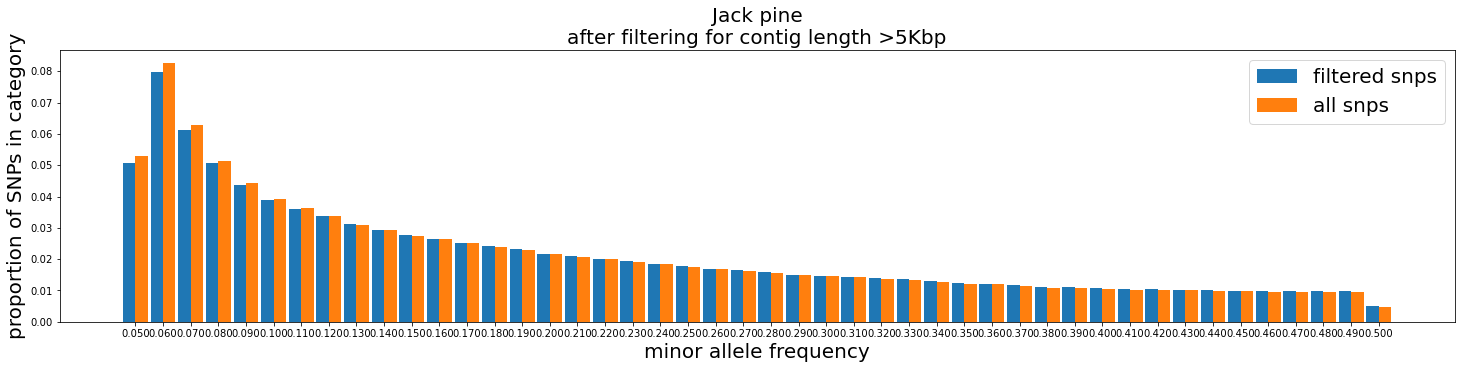

In [16]:
# compare MAF spectrum between depth-filtered and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter filtering for contig length >5Kbp')

<a id='missing'></a>
#### try and reduce to no missing data 

Turns out I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data. Filter instead for % missing below.

[top](#home)

In [17]:
def reduce_col(col):
    """Return list of loci with no missing data for pop.FREQ col."""
    return reduced[~reduced[col].isnull()].index

In [18]:
# get loci from each pop without missing data
reduce_col_outs = []
for col in nb(freqcols):
    reduce_col_outs.append(reduce_col(col))

100%|██████████| 39/39 [00:24<00:00,  1.57it/s]


In [19]:
# combine returns to get loci with no missing data across pop.FREQ cols
nomissingloci = snps.index.tolist()
for out in nb(reduce_col_outs):
    nomissingloci = list(set(nomissingloci).intersection(out))
len(nomissingloci), luni(nomissingloci)

100%|██████████| 39/39 [00:14<00:00,  2.69it/s]


(331095, 331095)

In [20]:
# reduce snp table to no missing loci
reduced_nm = reduced[reduced.index.isin(nomissingloci)]
reduced_nm.head()

,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ,unstitched_chrom,AF,MAF
>super4-47418,20%,18.57%,25.77%,21.17%,27.78%,34.34%,10.09%,23.45%,25.53%,37.82%,39.13%,19.59%,18.95%,15%,22.67%,13.39%,33.12%,10.64%,39.67%,14.29%,29.93%,4.04%,11%,27.85%,18.44%,27.27%,15.29%,49.62%,30.77%,32%,15.71%,5.88%,20%,15.91%,17.98%,19.64%,21.57%,9.92%,17.21%,>super4,0.220805,0.220805
>super4-47513,55.84%,56.39%,39.18%,50%,34.78%,52.43%,70.71%,56.62%,63.21%,48.41%,34.07%,45%,68%,41.94%,56.34%,65.12%,36%,55.77%,50%,58.02%,47.1%,63.64%,73.47%,47.62%,53.59%,57.55%,60.24%,32.77%,47.3%,28.46%,64.62%,64.18%,54%,63.04%,46.99%,49.14%,55.56%,69.78%,49.17%,>super4,0.529540,0.470460
>super4-47619,92%,95.16%,90.8%,84.26%,80.77%,81.97%,93.2%,91.2%,94.21%,89.66%,85.33%,85.34%,90.91%,88.98%,90.77%,95.35%,77.04%,91.18%,95.38%,84.09%,81.89%,92%,96.7%,81.93%,86.52%,84.62%,83.72%,82.54%,84.29%,91.04%,65.22%,94.2%,90.72%,97.87%,86.67%,94.44%,92.93%,82.81%,76.99%,>super4,0.878001,0.121999
>super4-47629,95.65%,95.16%,90.7%,86.24%,79.26%,84.03%,92.31%,91.38%,96.69%,89.77%,85.23%,84.62%,90.5%,89.23%,91.43%,95.45%,77.52%,93.07%,94.96%,84.62%,82.31%,94.52%,97.67%,82.76%,88%,86.4%,86.52%,82.68%,82.58%,91.11%,65.28%,95.08%,90.53%,97.96%,86.49%,94.89%,93.07%,80%,78.45%,>super4,0.882972,0.117028
>super4-47977,85.42%,98.31%,97.06%,83.54%,82.05%,86.67%,83.33%,92.77%,98.08%,92.75%,72.06%,89.29%,94.74%,93.67%,85.11%,93.42%,90.91%,76.36%,98.85%,98.11%,89.61%,90.7%,81.48%,91.07%,86.49%,98.48%,86%,82%,90.16%,87.14%,82.35%,100%,88.31%,96%,84.85%,100%,100%,89.69%,82.81%,>super4,0.897386,0.102614


46
46


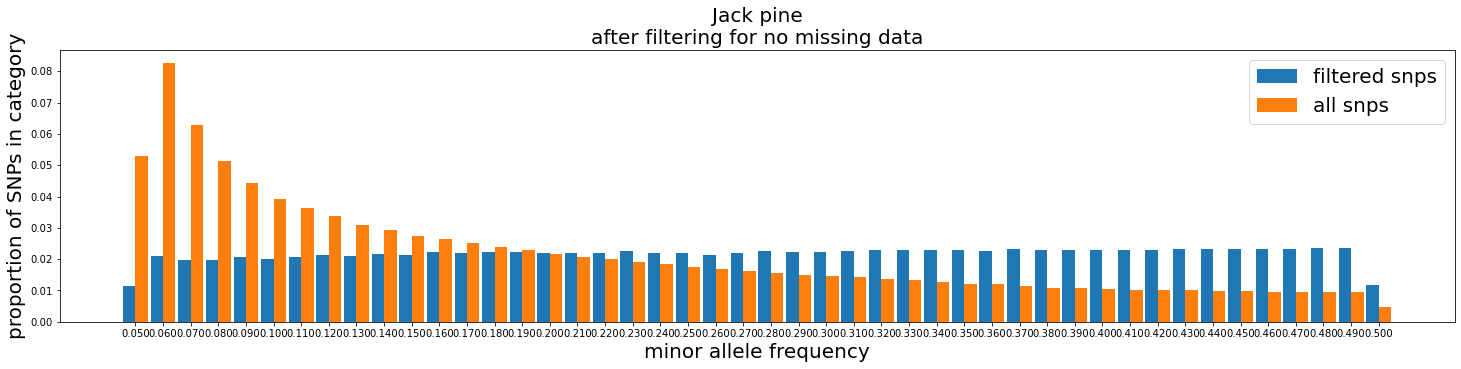

In [21]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced_nm['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter filtering for no missing data')

#### try to reduce to X% missing data ... 

In [22]:
def filter_perc(df, perc=0.10):
    """Filter df for missing data below perc."""
    import pandas
    from tqdm.notebook import tqdm as tnb
    
    freqcols = [col for col in df.columns if '.FREQ' in col]
    keep = []
    for locus in tnb(df.index):
        if sum(df.loc[locus,:].isnull())/len(freqcols) <= perc:
            keep.append(locus)
    return keep

In [23]:
# see how filtering affects congruence between pre- and post-filtered data (figs below)
jobs = []
tosend = []
i = 0
for locus in tnb(reduced.index):
    tosend.append(locus)
    if len(tosend) == 21732 or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :]))  # see fig below
#         jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :], **{'perc':0.2}))  # see fig below
        tosend = []
    i += 1
watch_async(jobs)

  0%|          | 0/946189 [00:00<?, ?it/s]


Watching 44 jobs ...


100%|██████████| 44/44 [00:04<00:00,  9.77it/s]


In [24]:
# gather parallel jobs
perc_loci = []
for j in jobs:
    perc_loci.extend(j.r)
len(perc_loci)

564066

46
46


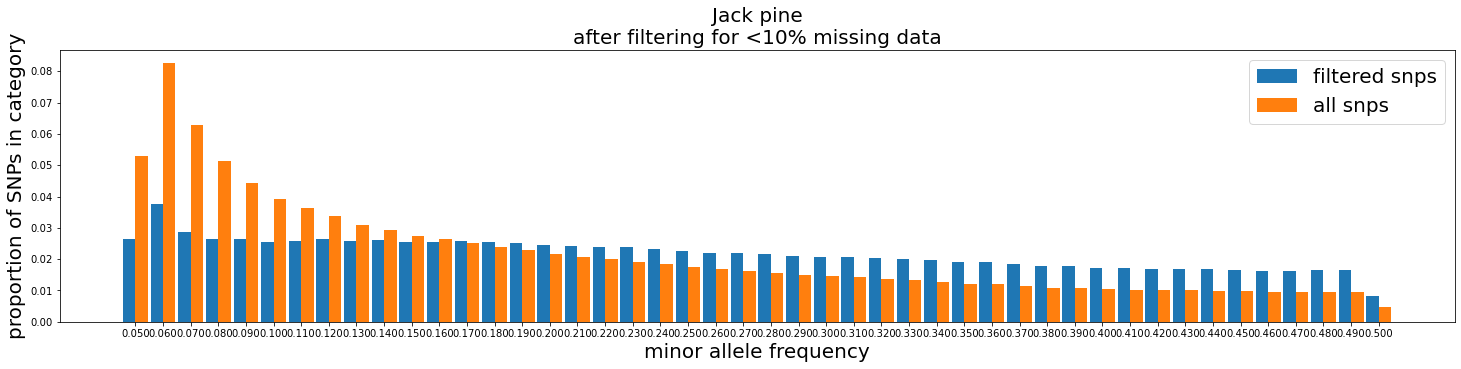

In [25]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter filtering for <10% missing data')

In [26]:
# see how filtering affects congruence between pre- and post-filtered data (figs below)
jobs = []
tosend = []
i = 0
for locus in tnb(reduced.index):
    tosend.append(locus)
    if len(tosend) == 21732 or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :], **{'perc':0.2}))  # see fig below
        tosend = []
    i += 1
watch_async(jobs)

  0%|          | 0/946189 [00:00<?, ?it/s]


Watching 44 jobs ...


100%|██████████| 44/44 [00:04<00:00,  9.18it/s]


In [27]:
# gather parallel jobs
perc_loci = []
for j in jobs:
    perc_loci.extend(j.r)
len(perc_loci)

878112

46
46


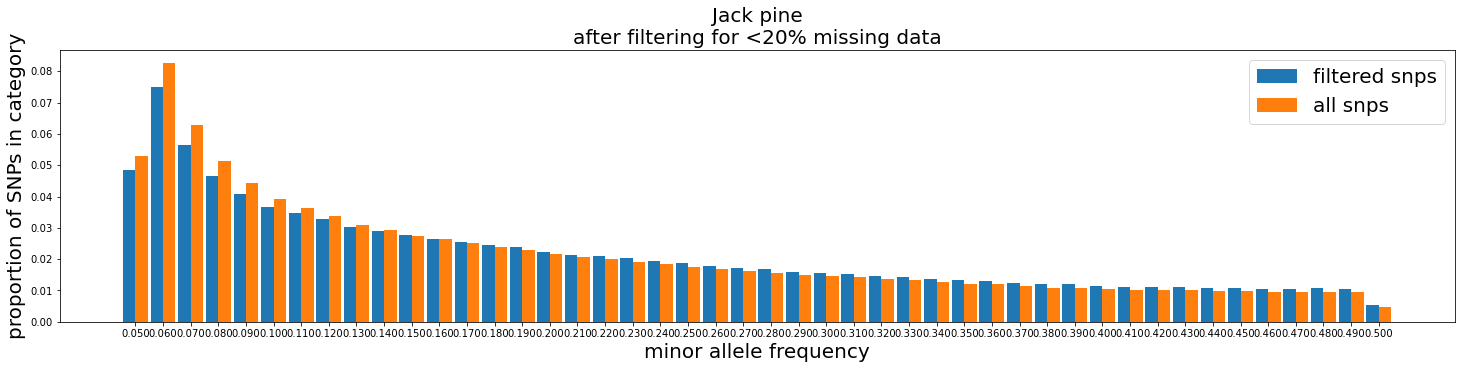

In [28]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter filtering for <20% missing data')

<center> SETTING PERC TO 0.25 MEANS NO LOCI WERE FILTERED BY MAF </center>

if I tried filtering <= 10% missing data, the MAF spectrum looked weird, leaving the code inplace. As-is (<25% missing data) will allow more contigs

<a id='random'></a>
#### choose one snp per contig at random

[top](#home)

In [29]:
def choose_random_loci(df):
    """For each chrom in df['unstitched_chrom'], randomly choose 1 snp."""
    import pandas
    import random

    keep = []
    for chrom in uni(df['unstitched_chrom']):
        loci = df.loc[chrom, 'unstitched_locus']
        if isinstance(loci, str):
            keep.append(loci)
            continue
        loci = loci.tolist()
        random.shuffle(loci)
        keep.append(loci[0])
    return keep
        
dview['uni'] = uni

In [30]:
reduced.shape

(946189, 42)

In [31]:
# change the index for easy sending
reduced['unstitched_locus'] = reduced.index.tolist()
reduced.index = reduced['unstitched_chrom'].tolist()

In [32]:
print(nrow(reduced), luni(reduced['unstitched_locus']))
reduced.head()

946189 946189


,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ,unstitched_chrom,AF,MAF,unstitched_locus
>super4,NaN,9.09%,21.18%,8.27%,13.56%,NaN,4.71%,NaN,7.92%,6.25%,5.3%,8.65%,8.65%,18.4%,NaN,18.7%,NaN,20%,2.46%,13.33%,NaN,7.45%,14.89%,2.63%,5.98%,NaN,2.56%,6.72%,6.34%,25.38%,0%,28.33%,19.81%,18.18%,9.09%,NaN,13.59%,0%,8.57%,>super4,0.108624,0.108624,>super4-47333
>super4,20%,18.57%,25.77%,21.17%,27.78%,34.34%,10.09%,23.45%,25.53%,37.82%,39.13%,19.59%,18.95%,15%,22.67%,13.39%,33.12%,10.64%,39.67%,14.29%,29.93%,4.04%,11%,27.85%,18.44%,27.27%,15.29%,49.62%,30.77%,32%,15.71%,5.88%,20%,15.91%,17.98%,19.64%,21.57%,9.92%,17.21%,>super4,0.220805,0.220805,>super4-47418
>super4,0%,0%,NaN,7.5%,16.52%,NaN,NaN,7.09%,2.08%,8.97%,15.15%,9.64%,5.06%,10.92%,13.16%,1.65%,19.05%,1.18%,1.72%,3.57%,16.78%,NaN,3.06%,15.19%,9.93%,11.76%,NaN,11.19%,6.06%,10.34%,NaN,0%,NaN,0%,11.9%,1.96%,2.2%,19.51%,19.2%,>super4,0.082141,0.082141,>super4-47461
>super4,55.84%,56.39%,39.18%,50%,34.78%,52.43%,70.71%,56.62%,63.21%,48.41%,34.07%,45%,68%,41.94%,56.34%,65.12%,36%,55.77%,50%,58.02%,47.1%,63.64%,73.47%,47.62%,53.59%,57.55%,60.24%,32.77%,47.3%,28.46%,64.62%,64.18%,54%,63.04%,46.99%,49.14%,55.56%,69.78%,49.17%,>super4,0.529540,0.470460,>super4-47513
>super4,0%,0%,0%,11%,16.53%,2.8%,0.93%,7.03%,0%,6.83%,10.49%,8.91%,2.31%,9.38%,NaN,0%,11.56%,0%,1.67%,5.13%,16.55%,0%,4.04%,3.49%,11.64%,7.81%,NaN,16.39%,6.72%,7.63%,2.99%,0%,NaN,0%,1.2%,0%,0%,2.19%,12.82%,>super4,0.052248,0.052248,>super4-47541


In [33]:
# choose random loci (one per contig) in parallel
jobs = []
tosend = []
i = 0
thresh = math.ceil(luni(reduced['unstitched_chrom'])/len(lview))  # how many chroms do I send to one job?
numchroms = luni(reduced['unstitched_chrom'])
for chrom in pbar(uni(reduced['unstitched_chrom']), desc='sending jobs'):
    tosend.append(chrom)
    if len(tosend)==thresh or (i+1)==numchroms:
        jobs.append(lview.apply_async(choose_random_loci, reduced.loc[tosend, :]))
        tosend = []
    i += 1
watch_async(jobs)

sending jobs: 100%|██████████| 39287/39287 [00:15<00:00, 2567.72it/s]



Watching 56 jobs ...


100%|██████████| 56/56 [00:00<00:00, 278625.18it/s]


In [34]:
# get returns from jobs
randomloci = []
for i,j in enumerate(jobs):
    randomloci.extend(j.r)
len(randomloci) == luni(reduced['unstitched_chrom'])

True

In [35]:
# reset index, reduce reduced to only randomloci
red = reduced[reduced['unstitched_locus'].isin(randomloci)].copy()
print(nrow(red), len(randomloci))
red.head()

39287 39287


,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ,unstitched_chrom,AF,MAF,unstitched_locus
>super4,NaN,23.91%,55.77%,8.64%,29.58%,12.12%,5.63%,29.35%,31.25%,25.49%,24.59%,28.36%,25.29%,30.86%,13.43%,15.73%,19.05%,18.46%,18.29%,20.83%,34.38%,20%,26.09%,16.67%,20%,21.15%,NaN,36.71%,20.9%,55.22%,5.88%,NaN,20.79%,NaN,17.07%,20%,27.5%,3.41%,29.31%,>super4,0.231872,0.231872,>super4-48836
>super27,47.62%,37.78%,38%,35%,36.51%,31.43%,34.43%,37.84%,31.91%,36.36%,22.22%,45.16%,47.22%,57.81%,27.08%,38.1%,34.62%,39.73%,31.82%,41.86%,35%,31.91%,40.43%,40%,29.55%,31.03%,NaN,40%,34.43%,35.14%,46.67%,44.44%,42.19%,52.78%,46.15%,30.36%,39.13%,48.15%,28.57%,>super27,0.381125,0.381125,>super27-574289
>super81,17.54%,30.23%,18.31%,44.9%,5.45%,10.71%,36.36%,NaN,23.33%,NaN,7.32%,9.3%,10.53%,14.55%,10.81%,11.38%,5%,30.1%,31.58%,18.6%,15.38%,NaN,6.67%,26.09%,21.88%,8.7%,6%,27.66%,19.44%,34.15%,21.43%,9.68%,19.67%,35%,35.71%,5.77%,6.25%,18.92%,8%,>super81,0.184280,0.184280,>super81-489921
>super124,0%,4.65%,3.57%,15.87%,2.56%,19.15%,16.84%,2.47%,0%,3.85%,NaN,18.67%,15.46%,4.76%,0%,10.26%,0%,8.25%,2.99%,9.09%,0%,2.94%,8.7%,1.69%,12.12%,4.48%,0%,5.97%,12.31%,15.49%,0%,8.51%,NaN,3.03%,3.77%,18.33%,NaN,0%,16.67%,>super124,0.070093,0.070093,>super124-717206
>super131,72.6%,61.54%,58.33%,75.86%,51.81%,68.09%,69.23%,54.88%,64.41%,48.72%,62%,62.07%,42.74%,57.65%,42.35%,73.4%,44.71%,55.29%,58.7%,78.87%,56.9%,57.35%,56.52%,63.33%,69.23%,76%,59.26%,35.9%,55%,54.32%,80%,81.25%,28.57%,62.5%,56.92%,65.57%,45.61%,58.46%,48.33%,>super131,0.593413,0.406587,>super131-87186


In [36]:
# reset index
reduced = red.copy()
reduced.index = reduced['unstitched_locus'].tolist()
reduced.shape

(39287, 43)

46
46


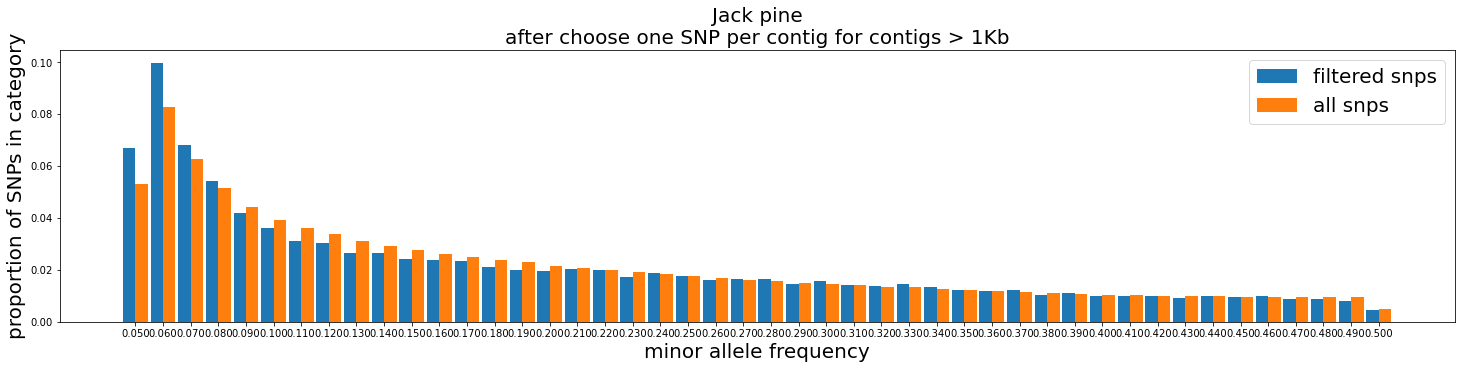

In [37]:
# compare distributions
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter choose one SNP per contig for contigs > 1Kb')

<a id='r2thresh'></a>
#### get an idea of r2 values so we can determine an empirical high-end cutoff

[top](#home)

In [38]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    rets = []
    for locus in myloci:
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci, **kwargs):
#     from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                r2 = freqs[locusi].corr(freqs[locusj])**2
#                 nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
#                 r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [39]:
len(randomloci)

39287

In [42]:
jobs = send_chunks(getr2, randomloci, 240, lview)
watch_async(jobs)


Watching 164 jobs ...


100%|██████████| 164/164 [00:46<00:00,  3.52it/s]


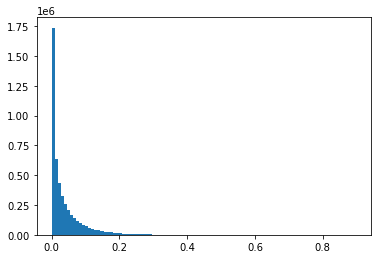

In [43]:
r2vals = []
for j in jobs:
    if j.ready():
        r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [44]:
# what is 99.99th percentile?
sorted_r2s = sorted(r2vals)
sorted_r2s[math.ceil(len(r2vals)*.9999)]

0.5236296606523496

In [45]:
# get an
sorted_r2s[math.ceil(len(r2vals)*.999)]

0.3757302229115432

In [46]:
# get 99.5th percentile
sorted_r2s[math.ceil(len(r2vals)*.995)]

0.2776911022572324

In [47]:
# what is 99th percentile?
sorted_r2s[math.ceil(len(r2vals)*.99)]

0.2368782820554887

In [48]:
# what is 98th percentile?
sorted_r2s[math.ceil(len(r2vals)*.98)]

0.19565323044528082

In [49]:
# what is 97th percentile?
sorted_r2s[math.ceil(len(r2vals)*.97)]

0.17183394883752426

In [50]:
# what perc is 0.2
for i,x in enumerate(sorted_r2s):
    if x > 0.2:
        print(i)  # how many loci are below this perc?
        break
(i+1)/len(r2vals)

4601612


0.9814259855768154

In [51]:
# what perc is 0.3
for i,x in enumerate(sorted_r2s):
    if x > 0.3:
        print(i)  # how many loci are below this perc?
        break
(i+1)/len(r2vals)

4672578


0.9965615209841703

In [52]:
# use 99.9th percentile
# I could not get loci from 99.5th percentile to converge on cov matrix ~ 2853 loci
# 99th percentile resulted in too few loci to estimate omega
r2thresh = 0.3757302229115432

<a id='prune'></a>
#### LD prune random loci

[top](#home)

In [53]:
# number of loci starting out
reduced.shape

(39287, 43)

In [54]:
len(randomloci)

39287

In [55]:
snps.shape, reduced.shape

((994997, 82), (39287, 43))

In [56]:
# num pops
len(freqcols)

39

In [ ]:
# attach data to engines

# dict with key=locus, val = list of freqs for that locus
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))

In [64]:
lview,dview = get_client()

56 56


In [65]:
dview['freqs'] = freqs
len(freqs)

39287

In [58]:
def prune_em(compareto, locusi=None, r2thresh=0.2):
    """Prune loci by LD (r2thresh)."""
#     from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
#         nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
#         r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
        r2 = freqs[locusi].corr(freqs[locusj])**2
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [59]:
r2thresh

0.3757302229115432

In [66]:
# test function
tosend = randomloci[1:10]
jobs = [lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':randomloci[0]})]
watch_async(jobs)
jobs[0].r


Watching 1 jobs ...


100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


('>scaffold185066-49892', [])

In [67]:
# send locus along with all needed loci for pairwise comparisons to engines
# each locus (job) has r2 calculated for each of the remaining unique pairwise combinations
# so the first job compares locus1 to locus2-locusn, second job locus2 to locus3-locusn ... 
jobs = []
i = 0
for locusi in pbar(randomloci):
    tosend = randomloci[i+1:] # pairwise comparisons
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))
    i += 1

100%|██████████| 39287/39287 [13:03<00:00, 50.15it/s]  


In [84]:
# iterate jobs, if finished jobs are an unbroken sequenced 0:(n-1), check returns and cancel any loci iterations
    # downstream. eg if locus0 has r2 > r2thresh with locus100, drop locus100 and kill jobs[100] to save some time

found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0  # jcount
    for j in nb(jobs):
        if j.ready() and i-1 in found.keys() and i not in found.keys():
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(True, 39285, 39287, 11878)


100%|██████████| 39287/39287 [00:00<00:00, 778395.33it/s]


11878

In [85]:
# save
baydir = makedir(op.join(snpdir, 'baypass'))
pkl = op.join(baydir, 'nomissing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p37573.pkl')
pkldump(keep, pkl)

46
46


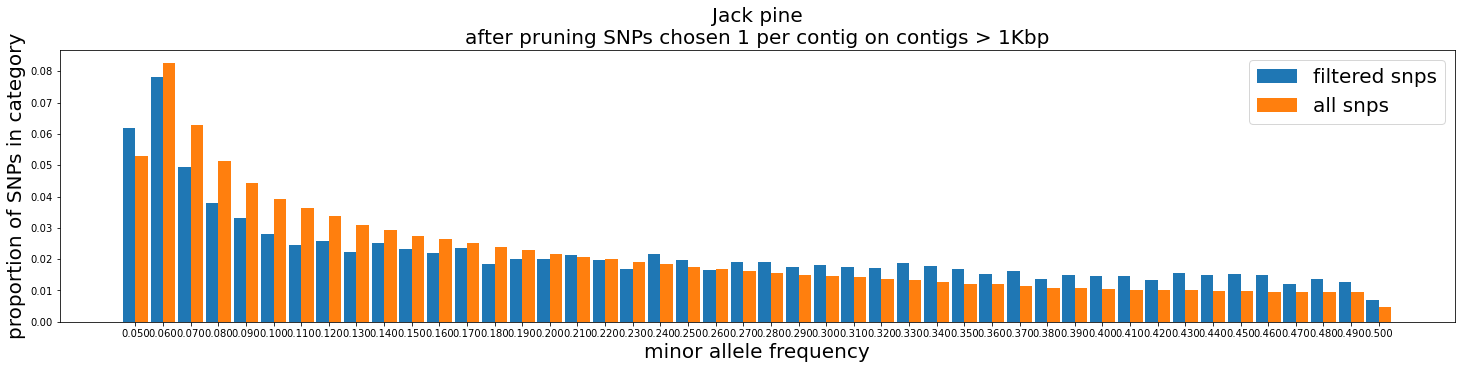

In [86]:
# compare distributions
keeping = reduced[reduced.index.isin(keep)].copy()
make_mafdict_fig(get_mafdict(keeping['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter pruning SNPs chosen 1 per contig on contigs > 1Kbp')

<a id='infiles'></a>
# create infiles to baypass to estimate neutral structure

[top](#home)

<a id='genotyping'></a>
#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [2]:
# RESTART NOTEBOOK! I used lower depth threshold for structure estimationb
latest_commit()

##################################################################
Current commit of pythonimports:
commit b1d8bd7312fbf3c6afef4ad9ea2585831ec509a5
Author: Brandon Lind <lindb@vcu.edu>
Date:   Fri Feb 12 12:21:51 2021 -0500
Today:	February 12, 2021 - 15:47:12
python version: 3.8.5
##################################################################



In [4]:
# see what's in baydir
fs(baydir, bnames=True, dirs=False)

['neutral_gfile_HEADERIDX.txt',
 'neutral_gfile_noheaderidx.txt',
 'neutral_rsync_cmds.txt',
 'nomissing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p37573.pkl',
 'poolsizefile_HEADERIDX.txt',
 'poolsizefile_noheaderidx.txt']

In [6]:
# load LD-pruned loci
prunedloci = pklload(op.join(baydir, 'nomissing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p37573.pkl'))
len(prunedloci)

11878

In [7]:
# get the file
snpfile = fs(snpdir, 'SNP', endswith='.txt')[0]
snpfile

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt'

In [8]:
# read in snps in parallel, reduce to the LD pruned loci
snps = parallel_read(snpfile, lview=lview, verbose=False)
snps.index = snps['unstitched_locus'].tolist()
reduced = snps[snps.index.isin(prunedloci)].copy()
reduced.head()


Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:25<00:00,  2.17it/s]


Function `parallel_read` completed after : 0-00:00:56


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,JP_p14.PVAL,JP_p14.AD,JP_p14.RD,JP_p70.GT,JP_p70.GQ,JP_p70.SDP,JP_p70.DP,JP_p70.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,MAF,unstitched_chrom,unstitched_pos,unstitched_locus
>super124-717206,Scaffold_4,717206,T,C,0.070093,-10.0,SNP,PASS,70,24,16,0,0,T/T,157.0,83.0,83.0,0%,1.000000e+00,0.0,83.0,T/T,60.0,43.0,43.0,4.65%,2.470600e-01,2.0,41.0,T/T,120.0,84.0,84.0,3.57%,1.227500e-01,3.0,81.0,T/C,31.0,63.0,63.0,15.87%,6.633800e-04,10.0,53.0,T/T,119.0,78.0,78.0,2.56%,...,33.0,3.03%,5.000000e-01,1.0,32.0,T/T,78.0,53.0,53.0,3.77%,2.476200e-01,2.0,51.0,T/C,35.0,60.0,60.0,18.33%,2.952600e-04,11.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T/T,164.0,88.0,88.0,0%,1.000000e+00,0.0,88.0,T/C,41.0,78.0,78.0,16.67%,7.083600e-05,13.0,65.0,Scaffold_4-717206,0.070093,>super124,717206,>super124-717206
>super345-177539,Scaffold_9,177539,A,C,0.629181,-10.0,SNP,PASS,64,0,36,4,0,A/C,134.0,56.0,56.0,60.71%,3.627900e-14,34.0,22.0,A/C,104.0,41.0,41.0,63.41%,3.826200e-11,26.0,15.0,A/C,198.0,82.0,82.0,60.98%,1.397900e-20,50.0,32.0,A/C,223.0,80.0,80.0,67.5%,4.314600e-23,54.0,26.0,A/C,252.0,71.0,71.0,78.87%,...,30.0,76.67%,8.705500e-11,23.0,7.0,A/C,150.0,57.0,57.0,64.91%,9.508100e-16,37.0,20.0,A/C,158.0,51.0,51.0,72.55%,1.526300e-16,37.0,14.0,A/C,114.0,54.0,54.0,55.56%,3.180700e-12,30.0,24.0,A/C,156.0,62.0,62.0,62.9%,2.276900e-16,39.0,23.0,A/C,184.0,59.0,59.0,72.88%,3.510300e-19,43.0,16.0,Scaffold_9-177539,0.370819,>super345,177539,>super345-177539
>super530-663877,Scaffold_10,663877,C,T,0.103543,-10.0,SNP,PASS,234,0,40,0,0,C/T,43.0,215.0,215.0,6.51%,4.905400e-05,14.0,201.0,C/T,59.0,175.0,175.0,10.86%,1.138400e-06,19.0,156.0,C/T,71.0,223.0,223.0,10.31%,6.557500e-08,23.0,200.0,C/T,100.0,254.0,254.0,12.6%,8.215700e-11,32.0,222.0,C/T,74.0,290.0,290.0,8.28%,...,112.0,7.14%,3.432300e-03,8.0,104.0,C/T,40.0,172.0,172.0,7.56%,9.647200e-05,13.0,159.0,C/T,46.0,226.0,226.0,6.64%,2.397800e-05,15.0,211.0,C/T,97.0,236.0,236.0,13.14%,1.622900e-10,31.0,205.0,C/T,97.0,283.0,283.0,10.95%,1.953200e-10,31.0,252.0,C/T,134.0,254.0,254.0,16.54%,3.582000e-14,42.0,212.0,Scaffold_10-663877,0.103543,>super530,663877,>super530-663877
>super766-472312,Scaffold_16,472312,G,T,0.465721,-10.0,SNP,PASS,42,0,39,1,0,G/T,86.0,44.0,44.0,52.27%,2.313600e-09,23.0,21.0,G/T,44.0,39.0,39.0,33.33%,3.683700e-05,13.0,26.0,G/T,56.0,38.0,38.0,42.11%,2.053500e-06,16.0,22.0,G/T,83.0,41.0,41.0,53.66%,4.813700e-09,22.0,19.0,G/T,79.0,50.0,50.0,44%,...,NaN,NaN,NaN,NaN,NaN,G/T,77.0,55.0,55.0,40%,1.707600e-08,22.0,33.0,G/T,78.0,40.0,40.0,52.5%,1.299700e-08,21.0,19.0,G/T,40.0,38.0,38.0,31.58%,8.727600e-05,12.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G/T,51.0,42.0,42.0,35.71%,6.662200e-06,15.0,27.0,Scaffold_16-472312,0.465721,>super766,472312,>super766-472312
>super796-436334,Scaffold_17,436334,G,A,0.051208,-10.0,SNP,PASS,51,30,10,0,0,G/G,77.0,42.0,42.0,0%,1.000000e+00,0.0,42.0,G/A,21.0,63.0,63.0,11.11%,6.552900e-03,7.0,56.0,G/G,62.0,50.0,50.0,6%,1.212100e-01,3.0,47.0,G/G,88.0,69.0,69.0,5.8%,5.977300e-02,4.0,65.0,NaN,NaN,NaN,NaN,NaN,...,43.0,2.33%,5.000000e-01,1.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G/G,49.0,46.0,46.0,8.7%,5.840200e-02,4.0,42.0,G/A,22.0,46.0,46.0,15.22%,6.109700e-03,7.0,39.0,G/G,97.0,

In [9]:
# all LD-pruned loci are in full set? A: yes!
assert len(set(prunedloci).intersection(reduced.index)) == len(prunedloci)

In [10]:
# how many pops?
len([col for col in reduced.columns if '.FREQ' in col])

39

In [7]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
    assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            # this matches calculation of MAF from 001_JP_pooled_pangenome_data_explore.ipynb
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [13]:
# create the neutral gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci, numpops=39)
neutral_read_counts.head()

100%|██████████| 11878/11878 [00:21<00:00, 541.40it/s]


,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>scaffold185066-49892,113,47,109,68,130,79,123,68,99,51,121,63,123,72,128,54,81,34,92,53,76,45,111,61,123,80,103,68,121,42,227,96,128,49,208,74,120,67,125,65,118,58,98,43,90,49,126,59,96,56,147,88,111,53,111,37,113,72,115,53,155,68,57,24,151,54,47,26,87,36,78,67,103,53,97,56,100,58
>C4157323-811,45,0,30,3,25,1,31,0,35,0,21,10,0,0,21,0,41,0,0,0,19,1,24,7,32,0,0,0,0,0,48,0,44,15,0,0,36,32,47,8,42,13,37,7,20,7,22,14,31,3,26,14,10,11,20,0,30,10,25,2,13,23,0,0,29,9,0,0,39,0,15,9,27,7,48,4,32,0
>C5150541-70578,33,9,20,24,24,23,38,3,18,27,10,16,32,10,19,10,38,2,35,11,11,18,22,22,21,15,12,31,6,21,44,19,8,15,42,13,38,14,25,16,24,24,20,3,24,8,21,15,28,13,27,24,14,25,25,13,18,16,21,26,24,20,0,0,29,20,15,8,40,0,12,24,14,24,0,0,17,28
>scaffold208938-31877,54,12,0,0,65,21,32,17,36,11,21,7,59,12,49,18,41,3,30,8,34,10,44,10,48,17,38,7,26,9,94,35,48,15,72,28,47,9,60,25,42,12,43,7,22,7,35,4,49,9,21,12,21,4,40,2,33,15,30,13,29,10,36,13,48,10,0,0,30,2,17,8,36,8,39,11,38,12
>scaffold199707-4480,47,33,29,47,54,61,124,29,75,57,66,20,76,59,95,45,51,65,64,84,77,60,47,49,89,57,59,33,45,33,65,86,70,98,55,77,60,64,78,50,81,56,55,45,34,48,49,35,75,49,86,37,35,14,73,58,59,37,28,72,38,32,38,43,69,64,29,38,56,45,60,48,53,36,87,27,27,78


In [22]:
# assert that DP = RD + AD
dpcols = [col for col in reduced.columns if '.DP' in col]
for dpcol in dpcols:
    pop = dpcol.split(".")[0]
    adcol = f"{pop}.AD"
    rdcol = f"{pop}.RD"
    df = reduced[reduced[dpcol].notnull()]
    assert all(df[dpcol] == (df[adcol]+df[rdcol]))

In [23]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'

In [24]:
# make sure missing data makes sense
majorcols = [col for col in neutral_read_counts.columns if 'major' in col]
print(len(majorcols))  # num pops
for locus in neutral_read_counts.index:
    misscount = 0
    for col in majorcols:
        pop = col.split("-")[0]
        if neutral_read_counts.loc[locus, col] == 0 and neutral_read_counts.loc[locus, "%s-minor" % pop] == 0:
            misscount += 1
    if misscount / len(majorcols) > 0.25:
        print('crap ', locus)

39


In [25]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

<a id='poolsizefile'></a>
#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

</center>

[top](#home)

In [26]:
DIR

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled'

In [27]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'pkl_files/ploidy.pkl'))['JP_pooled']  # get correct order
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

JP_p98 40
JP_p73 40
JP_p97 40
JP_p60 40
JP_p100 40


In [28]:
Counter(ploidy.values())

Counter({40: 35, 34: 1, 38: 4})

In [29]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [30]:
# num pops
len(poolsizefile.columns)

39

In [31]:
# compare pop order to poolsizefile
neutral_read_counts.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>scaffold185066-49892,113,47,109,68,130,79,123,68,99,51,121,63,123,72,128,54,81,34,92,53,76,45,111,61,123,80,103,68,121,42,227,96,128,49,208,74,120,67,125,65,118,58,98,43,90,49,126,59,96,56,147,88,111,53,111,37,113,72,115,53,155,68,57,24,151,54,47,26,87,36,78,67,103,53,97,56,100,58
>C4157323-811,45,0,30,3,25,1,31,0,35,0,21,10,0,0,21,0,41,0,0,0,19,1,24,7,32,0,0,0,0,0,48,0,44,15,0,0,36,32,47,8,42,13,37,7,20,7,22,14,31,3,26,14,10,11,20,0,30,10,25,2,13,23,0,0,29,9,0,0,39,0,15,9,27,7,48,4,32,0
>C5150541-70578,33,9,20,24,24,23,38,3,18,27,10,16,32,10,19,10,38,2,35,11,11,18,22,22,21,15,12,31,6,21,44,19,8,15,42,13,38,14,25,16,24,24,20,3,24,8,21,15,28,13,27,24,14,25,25,13,18,16,21,26,24,20,0,0,29,20,15,8,40,0,12,24,14,24,0,0,17,28
>scaffold208938-31877,54,12,0,0,65,21,32,17,36,11,21,7,59,12,49,18,41,3,30,8,34,10,44,10,48,17,38,7,26,9,94,35,48,15,72,28,47,9,60,25,42,12,43,7,22,7,35,4,49,9,21,12,21,4,40,2,33,15,30,13,29,10,36,13,48,10,0,0,30,2,17,8,36,8,39,11,38,12
>scaffold199707-4480,47,33,29,47,54,61,124,29,75,57,66,20,76,59,95,45,51,65,64,84,77,60,47,49,89,57,59,33,45,33,65,86,70,98,55,77,60,64,78,50,81,56,55,45,34,48,49,35,75,49,86,37,35,14,73,58,59,37,28,72,38,32,38,43,69,64,29,38,56,45,60,48,53,36,87,27,27,78


In [32]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

<a id='covariance'></a>
#  create 5 replicate estimates of the covariance matrix


[top](#home)

In [33]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'

<a id='shfiles'></a>
## make shfiles for graham server

[top](#home)

In [34]:
# get gfile and poolsize file paths
gfile = op.join(baydir, 'neutral_gfile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'poolsizefile_noheaderidx.txt')
all([op.exists(gfile), op.exists(poolsizefile)])

True

In [35]:
gfile

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_gfile_noheaderidx.txt'

In [36]:
poolsizefile

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/poolsizefile_noheaderidx.txt'

In [40]:
# create sbatch files to run baypass omega estimation

# cedar paths to files (I rsynced files here to cedar server)
c_gfile = '/scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt'
c_poolsizefile = '/scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt'
shdir = makedir(op.join(baydir, 'neutral_runs/graham_shfiles'))

# create sbatch files to submit on cedar server
shfiles = []
for i in range(5):
    seed = random.randint(1,100000000)
    file = op.join(shdir, 'cedar_chain_%s.sh' % str(i+1))
    shfiles.append(file)
    cmd = f'i_baypass -gfile {c_gfile} -poolsizefile {c_poolsizefile} \
-seed {seed} \
-print_omega_samples \
-outprefix chain_{i+1} \
-nthreads 10'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i+1}
#SBATCH --time=1-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25M
#SBATCH --cpus-per-task=10
#SBATCH --output=chain_{i+1}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

cat $0

#module load intel/2019.3  # for arc, not needed for cedar

export PATH="${{PATH}}:/home/lindb/src/baypass_2.2/sources"

cd /scratch/lindb/jp_gea

{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 20543989 -print_omega_samples -outprefix chain_1 -nthreads 10 

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 7061177 -print_omega_samples -outprefix chain_2 -nthreads 10 

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 87538186 -print_omega_samples -outprefix chain_3 -nthreads 10 

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 633719 -print_omega_samples -outprefix chain_4 -nthreads 10 

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 88973485 -print_omega_samples -outprefix chain_

In [43]:
# scp the files to cedar and run
jobs = []
for src in shfiles+[gfile, poolsizefile]:
    dst = src.replace(baydir, 'graham:/scratch/lindb/jp_gea')
    jobs.append(lview.apply_async(rsync, *(src,dst)))
watch_async(jobs)


Watching 7 jobs ...


100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


In [45]:
# double check for errors
for j in jobs:
    x = j.r
x

['sending incremental file list',
 'poolsizefile_noheaderidx.txt',
 '',
 'sent 148 bytes  received 35 bytes  122.00 bytes/sec',
 'total size is 117  speedup is 0.64',
 '']

In [ ]:
# go to graham and sbatch files

<a id='look'></a>
# look at covariance matrices output from chains

[top](#home)

In [2]:
# RESTART NOTEBOOK!
latest_commit()

##################################################################
Current commit of pythonimports:
commit b1d8bd7312fbf3c6afef4ad9ea2585831ec509a5
Author: Brandon Lind <lindb@vcu.edu>
Date:   Fri Feb 12 12:21:51 2021 -0500
Today:	February 12, 2021 - 16:09:52
python version: 3.8.5
##################################################################



<a id='rersync'></a>
#### rsync the files from cedar HPC

[top](#home)

In [3]:
rsyncfile = op.join(baydir, 'neutral_rsync_cmds.txt')
cmds = read(rsyncfile, lines=True)
print(len(cmds))
cmds[0]

35


'rsync -azv graham:/scratch/lindb/jp_gea/chain_1_DIC.out /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_1_DIC.out'

In [4]:
# rsync in parallel
jobs = []
for cmd in cmds:
    *args,src,dst = cmd.split()
    jobs.append(lview.apply_async(rsync, *(src, dst)))
watch_async(jobs)


Watching 35 jobs ...


100%|██████████| 35/35 [00:00<00:00, 36.08it/s]


In [5]:
# make sure they all transferred
for cmd in cmds:
    *args,src,dst = cmd.split()
    assert op.exists(dst)

<a id='readin'></a>
#### read in matrices and look at convergence

[top](#home)

In [6]:
# get the matrix files output for each chain
ndir = op.join(baydir, 'neutral_runs')
#ndir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/non-converged/nval_100000'
mfiles = fs(ndir, 'mat_omega.out')
mfiles

['/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_1_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_2_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_3_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_4_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_5_mat_omega.out']

In [7]:
ndir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_runs'

In [8]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

1521

In [9]:
np.sqrt(len(matrices[chain]))  # num pops

39.0

In [10]:
from scipy.stats import pearsonr

In [11]:
# look at pairwise correlations among chains
rs = []
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            res = pearsonr(matrices[chaini], matrices[chainj])
            rs.append(res[0])
            print(chaini,chainj, res)
np.mean(rs)

chain_1 chain_2 (0.9075437081824252, 0.0)
chain_1 chain_3 (0.9365025857819912, 0.0)
chain_1 chain_4 (0.9221481974031961, 0.0)
chain_1 chain_5 (0.9335407921276431, 0.0)
chain_2 chain_3 (0.9437844724160543, 0.0)
chain_2 chain_4 (0.9290956884176319, 0.0)
chain_2 chain_5 (0.9075691337045734, 0.0)
chain_3 chain_4 (0.956361335728787, 0.0)
chain_3 chain_5 (0.9491144496680989, 0.0)
chain_4 chain_5 (0.9198303690419066, 0.0)


0.9305490732472308

chain_1 chain_2 0.9043378699554786 0.0612728039372518


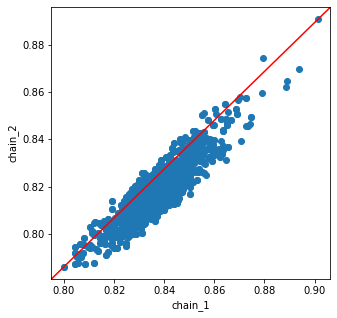

chain_1 chain_3 0.9394116095878261 0.03493420019350783


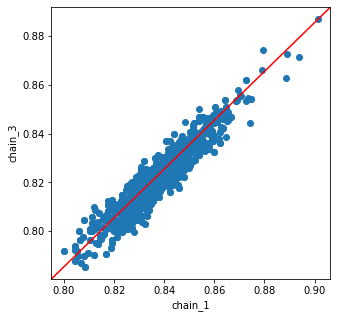

chain_1 chain_4 0.8628852723357314 0.06804178649596543


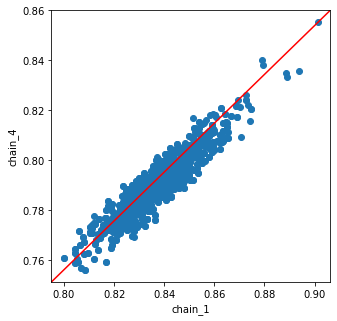

chain_1 chain_5 0.9328233374870452 0.02600556907953206


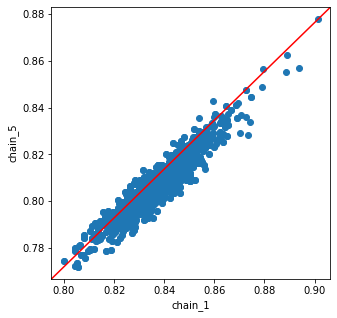

chain_2 chain_3 0.9500721829365968 0.04387064824270262


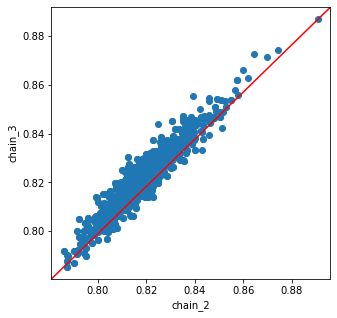

chain_2 chain_4 0.8724682111194539 0.07642142775464056


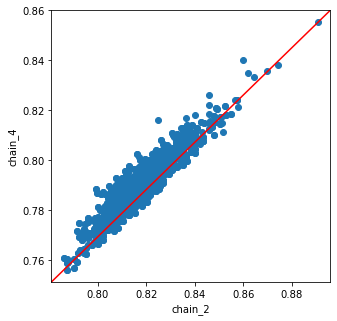

chain_2 chain_5 0.910086459405274 0.062144616924479604


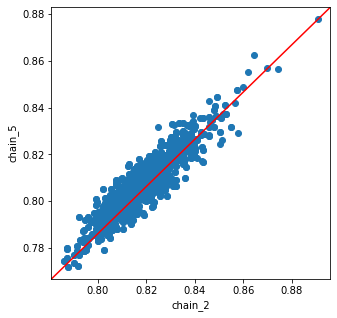

chain_3 chain_4 0.8921284774525657 0.05764191574702996


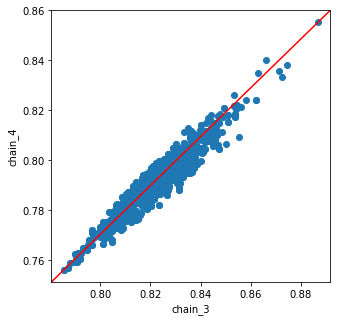

chain_3 chain_5 0.9454482149084055 0.03035688189424859


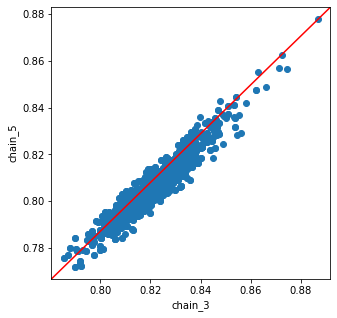

chain_4 chain_5 0.9822488121684698 0.030531795050920553


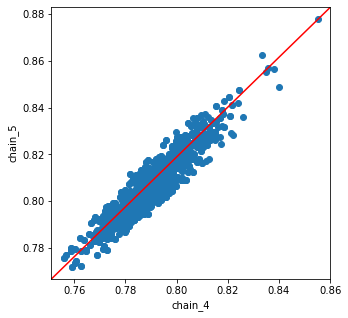

In [12]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

<a id='avg'></a>
#### estimate average covariance matrix

[top](#home)

In [13]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,0.856635,0.824694,0.841039,0.822946,0.822853,0.824537,0.829582,0.814709,0.807796,0.808069,0.806105,0.817747,0.811701,0.819549,0.826239,0.831785,0.819220,0.829656,0.820748,0.847699,0.820282,0.815592,0.822040,0.822678,0.805614,0.822643,0.828995,0.807288,0.815361,0.818272,0.837112,0.829918,0.821613,0.831869,0.832244,0.815354,0.818434,0.815410,0.822980
1,0.824694,0.842951,0.826109,0.815289,0.813163,0.817613,0.807634,0.804762,0.789390,0.800736,0.798909,0.805485,0.803924,0.810428,0.818613,0.811566,0.812455,0.807638,0.809566,0.827595,0.813313,0.795387,0.808916,0.816883,0.794442,0.814512,0.818969,0.803254,0.808254,0.805098,0.830865,0.809187,0.810954,0.811511,0.813805,0.808992,0.808849,0.807652,0.812279
2,0.841039,0.826109,0.855013,0.824681,0.828307,0.827119,0.823598,0.817820,0.805967,0.811683,0.811349,0.822576,0.815736,0.826215,0.827282,0.827981,0.824077,0.824654,0.823289,0.844722,0.823573,0.810469,0.823944,0.825253,0.809021,0.824555,0.832510,0.809667,0.817179,0.820203,0.839169,0.825582,0.824051,0.828153,0.829699,0.820185,0.823355,0.817837,0.829349
3,0.822946,0.815289,0.824681,0.841990,0.810337,0.816040,0.805239,0.804093,0.788453,0.798200,0.796423,0.802960,0.802241,0.808271,0.817906,0.808782,0.809386,0.805804,0.808310,0.824594,0.810379,0.792867,0.804382,0.815124,0.795585,0.811684,0.815999,0.798634,0.805675,0.801735,0.828507,0.808112,0.808638,0.809247,0.811497,0.806511,0.806447,0.804272,0.808796
4,0.822853,0.813163,0.828307,0.810337,0.828300,0.812668,0.806672,0.804872,0.789280,0.797191,0.799534,0.807222,0.801769,0.815522,0.814705,0.811022,0.812842,0.807394,0.811282,0.827841,0.810950,0.793709,0.809097,0.810708,0.794689,0.811561,0.819061,0.796460,0.801500,0.804855,0.824509,0.809726,0.809806,0.811936,0.811777,0.807647,0.811637,0.804893,0.815882


In [14]:
# sum across each matrix (to use in average calc below)
for chain,m in mats.items():
    print(chain)
    if chain == 'chain_1':
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

chain_1
chain_2
chain_3
chain_4
chain_5


array([[4.322758, 4.140323, 4.23736 , ..., 4.144163, 4.105023, 4.146161],
       [4.140323, 4.214752, 4.145383, ..., 4.076496, 4.047294, 4.070885],
       [4.23736 , 4.145383, 4.303298, ..., 4.164777, 4.111458, 4.167371],
       ...,
       [4.144163, 4.076496, 4.164777, ..., 4.159108, 4.043403, 4.10153 ],
       [4.105023, 4.047294, 4.111458, ..., 4.043403, 4.193824, 4.038026],
       [4.146161, 4.070885, 4.167371, ..., 4.10153 , 4.038026, 4.189604]])

In [15]:
# calculate average netural matrix
avg = summatrix / len(mats)
avg.shape

(39, 39)

In [16]:
# convert to dataframe
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

(39, 39)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,0.864552,0.828065,0.847472,0.830326,0.830869,0.832412,0.839250,0.825688,0.817832,0.813322,0.816752,0.826231,0.820959,0.826291,0.835271,0.844637,0.824588,0.837646,0.829171,0.852790,0.825499,0.821362,0.834025,0.834961,0.813684,0.827458,0.835178,0.815388,0.824740,0.829014,0.843830,0.835392,0.831415,0.838698,0.837534,0.821954,0.828833,0.821005,0.829232
1,0.828065,0.842950,0.829077,0.819448,0.816971,0.822410,0.813405,0.812271,0.795782,0.803111,0.805796,0.809951,0.809332,0.813772,0.824283,0.820138,0.813662,0.812119,0.815318,0.828100,0.814072,0.798041,0.816678,0.825199,0.799420,0.815855,0.821529,0.808169,0.813866,0.812253,0.833639,0.810798,0.817448,0.814742,0.815105,0.811312,0.815299,0.809459,0.814177
2,0.847472,0.829077,0.860660,0.831541,0.835296,0.833919,0.832462,0.827634,0.814751,0.815421,0.819915,0.829324,0.823296,0.832106,0.835421,0.839848,0.828030,0.831617,0.830530,0.848576,0.827086,0.815132,0.834120,0.836067,0.816266,0.828668,0.837885,0.816773,0.824896,0.830124,0.843664,0.830340,0.833152,0.833947,0.833608,0.825178,0.832955,0.822292,0.833474
3,0.830326,0.819448,0.831541,0.850107,0.818043,0.824421,0.814835,0.815211,0.798190,0.803470,0.806757,0.811420,0.811124,0.814253,0.826719,0.821488,0.815327,0.813341,0.817201,0.829513,0.815485,0.798803,0.816676,0.826109,0.804471,0.817266,0.822645,0.806659,0.815353,0.812666,0.835271,0.812848,0.818381,0.815942,0.817005,0.812458,0.816081,0.810145,0.814809
4,0.830869,0.816971,0.835296,0.818043,0.837010,0.821555,0.816723,0.815930,0.799398,0.803048,0.810532,0.815904,0.811247,0.823049,0.823788,0.823894,0.818771,0.815582,0.819440,0.832735,0.816261,0.799728,0.820572,0.823072,0.803367,0.817108,0.825800,0.804705,0.811169,0.816076,0.830733,0.815536,0.820156,0.818385,0.817235,0.814291,0.822342,0.810557,0.821996


<a id='compare'></a>
#### compare avg matrix to replicate matrices

[top](#home)

In [17]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

1521 1521
chain_1 (0.9674572222690457, 0.0)
chain_2 (0.9648562964053068, 0.0)
chain_3 (0.9849498213244484, 0.0)
chain_4 (0.9721893836615613, 0.0)
chain_5 (0.9696376811857061, 0.0)


In [18]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'

In [19]:
# save average matrix
omegafile = op.join(baydir, 'neutral_average_omegafile_noheaderidx.txt')
avgmat.to_csv(omegafile, sep='\t', index=False, header=False)

#### make sure pops are in same order as gfile

In [20]:
# load poolsize file
poolsizefile = pd.read_table(op.join(baydir, 'poolsizefile_HEADERIDX.txt'))
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [21]:
# compare to columns on gfile
gfile = pd.read_table(op.join(baydir, 'neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

,JP_p98,JP_p31,JP_p93,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79


In [22]:
# compare computationally
list(poolsizefile.columns) == gfilecols

True

In [23]:
# put columns on matrix for archiving
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

,JP_p98,JP_p31,JP_p93,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
JP_p98,0.864552,0.828065,0.847472,0.830326,0.830869,0.832412,0.839250,0.825688,0.817832,0.813322,0.816752,0.826231,0.820959,0.826291,0.835271,0.844637,0.824588,0.837646,0.829171,0.852790,0.825499,0.821362,0.834025,0.834961,0.813684,0.827458,0.835178,0.815388,0.824740,0.829014,0.843830,0.835392,0.831415,0.838698,0.837534,0.821954,0.828833,0.821005,0.829232
JP_p31,0.828065,0.842950,0.829077,0.819448,0.816971,0.822410,0.813405,0.812271,0.795782,0.803111,0.805796,0.809951,0.809332,0.813772,0.824283,0.820138,0.813662,0.812119,0.815318,0.828100,0.814072,0.798041,0.816678,0.825199,0.799420,0.815855,0.821529,0.808169,0.813866,0.812253,0.833639,0.810798,0.817448,0.814742,0.815105,0.811312,0.815299,0.809459,0.814177
JP_p93,0.847472,0.829077,0.860660,0.831541,0.835296,0.833919,0.832462,0.827634,0.814751,0.815421,0.819915,0.829324,0.823296,0.832106,0.835421,0.839848,0.828030,0.831617,0.830530,0.848576,0.827086,0.815132,0.834120,0.836067,0.816266,0.828668,0.837885,0.816773,0.824896,0.830124,0.843664,0.830340,0.833152,0.833947,0.833608,0.825178,0.832955,0.822292,0.833474
JP_p14,0.830326,0.819448,0.831541,0.850107,0.818043,0.824421,0.814835,0.815211,0.798190,0.803470,0.806757,0.811420,0.811124,0.814253,0.826719,0.821488,0.815327,0.813341,0.817201,0.829513,0.815485,0.798803,0.816676,0.826109,0.804471,0.817266,0.822645,0.806659,0.815353,0.812666,0.835271,0.812848,0.818381,0.815942,0.817005,0.812458,0.816081,0.810145,0.814809
JP_p70,0.830869,0.816971,0.835296,0.818043,0.837010,0.821555,0.816723,0.815930,0.799398,0.803048,0.810532,0.815904,0.811247,0.823049,0.823788,0.823894,0.818771,0.815582,0.819440,0.832735,0.816261,0.799728,0.820572,0.823072,0.803367,0.817108,0.825800,0.804705,0.811169,0.816076,0.830733,0.815536,0.820156,0.818385,0.817235,0.814291,0.822342,0.810557,0.821996


In [24]:
# save pop labels
avgmat.to_csv(op.join(baydir, 'neutral_average_omegafile_HEADERIDX.txt'), index=True, header=True, sep='\t')

<a id='geainfiles'></a>
# create infiles for baypass GEA

[top](#home)

<a id='efile'></a>
## make efile

[top](#home)

In [25]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'

In [26]:
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [27]:
ncol(poolsizefile)  # num pops

39

In [28]:
# load center/standardized environmental data
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_std_env-19variables.txt')
envdata.index = envdata['our_id'].tolist()
envdata = envdata[envdata.index.isin(poolsizefile.columns)]
envdata.head()

,id1,id2,our_id,LAT,LONG,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group_color
JP_p98,9150251,38,JP_p98,54.3333,-106.6333,537,0.675175,0.520607,-0.903668,1.089738,-0.977280,-0.426821,-0.730607,-0.884497,-1.150172,-1.078601,-0.980098,-1.159142,-0.873067,0.024306,-0.875072,0.771358,0.796677,0.297097,-1.185008,#008000
JP_p73,3273,22,JP_p73,44.4200,-84.6800,359,0.836472,1.368359,1.495515,-1.369016,1.486357,0.679033,1.970275,1.047245,-0.089609,1.506884,1.449041,0.000330,1.202338,0.909053,-0.778393,0.304132,-1.205688,-0.729581,1.010494,#000000
JP_p97,8060006,37,JP_p97,56.1167,-116.9167,636,1.138905,1.382488,-1.202248,0.719680,-0.625332,-0.368618,-0.448998,-1.781378,-1.263664,-0.914443,-0.919871,-1.584282,-1.651344,-0.670852,-0.839916,0.994352,0.436701,0.737103,-2.282760,#008000
JP_p60,3260,17,JP_p60,46.7200,-84.3900,203,-0.272448,-0.129337,0.093943,-0.869081,0.927381,-0.659632,0.101418,0.495318,0.364358,0.645056,0.907002,0.026096,-0.224503,0.466680,0.320236,-0.311756,-1.093195,0.150429,1.010494,#ff00ff
JP_p100,9040116,40,JP_p100,55.7667,-97.8167,205,-0.917638,-0.199983,-1.852100,2.404514,-1.743285,-0.135807,-1.831440,-2.333304,-0.974064,-2.350824,-1.943723,-1.030312,-1.456774,-2.693131,-0.330152,0.293514,1.674118,2.497123,-1.843659,#008000


In [29]:
# check for 39 rows
envdata.shape

(39, 26)

In [30]:
# expecting 19 env variables
len(list(envdata.columns)[6:-1])

19

In [31]:
# triple check centered/standardized
for env in list(envdata.columns)[6:-2]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

AHM -8.098934628355308e-16 1.0000000000000002
CMD -6.832141690000964e-17 0.9999999999999998
DD5 3.7007434154171886e-16 0.9999999999999998
DD_0 0.0 1.0
EMT -2.0724163126336257e-15 0.9999999999999998
EXT -1.9236748945908962e-15 1.0
Eref -2.135044278125301e-16 0.9999999999999999
FFP 1.67956816545857e-16 1.0
MAP -3.416070845000482e-17 1.0
MAT -5.693451408334136e-17 0.9999999999999999
MCMT -4.725564668917333e-16 1.0
MSP 3.2452673027504574e-16 1.0
MWMT 1.1557706358918297e-15 1.0
NFFD 1.4536093126903091e-16 1.0
PAS -3.416070845000482e-17 0.9999999999999998
SHM -5.01023723933404e-16 1.0
TD -5.921189464667501e-16 1.0
bFFP -5.494180609042442e-16 1.0


In [34]:
# convert jp envdata to efile, making sure to order pops in same order as other files
efile = envdata.loc[poolsizefile.columns.tolist(), list(envdata.columns)[6:-1]]
efile.head()

,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
JP_p98,0.675175,0.520607,-0.903668,1.089738,-0.977280,-0.426821,-0.730607,-0.884497,-1.150172,-1.078601,-0.980098,-1.159142,-0.873067,0.024306,-0.875072,0.771358,0.796677,0.297097,-1.185008
JP_p31,-0.756340,-1.132510,-0.253816,0.095206,-0.335492,-0.310415,-0.372196,0.081374,0.380012,-0.134694,-0.197152,0.708897,-0.289359,-0.291675,0.522384,-0.885169,0.121723,0.150429,0.242068
JP_p93,1.179229,0.605382,0.564646,0.461706,-0.439006,1.261062,-0.231392,0.840272,-0.950583,-0.134694,-0.638814,-0.811300,0.878056,0.529876,-0.927806,1.185490,1.044160,-1.022918,0.571394
JP_p14,-1.220071,-1.245544,-0.499706,-0.418962,0.285593,-0.601430,-0.052186,-0.608534,1.248813,0.070504,0.445265,1.043855,-0.354216,-1.050029,1.831949,-1.129401,-0.620727,0.883771,-0.306807
JP_p70,0.050147,-0.072820,1.073989,-0.678714,0.368404,0.970048,1.355856,0.495318,0.188250,0.850253,0.585794,1.301516,1.137481,0.277091,-0.690502,-0.800219,-0.260752,-0.436244,0.461618


In [35]:
assert ncol(efile)==19

In [36]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,JP_p98,JP_p31,JP_p93,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
AHM,0.675175,-0.756340,1.179229,-1.220071,0.050147,-0.937800,0.735661,0.090471,0.493715,-1.462017,0.836472,0.876796,-1.099097,0.332418,-0.877313,0.836472,0.594526,1.179229,-0.776503,1.965554,0.070309,1.138905,1.259878,-1.562828,0.009823,-0.655529,0.513877,-0.937800,-1.764450,-1.159584,-1.361206,1.159067,-0.272448,0.251769,-0.917638,0.070309,2.167176,-0.756340,0.029985
CMD,0.520607,-1.132510,0.605382,-1.245544,-0.072820,-0.411921,0.859708,0.011955,0.195635,-1.528128,1.368359,0.506478,-1.118381,0.280410,-0.821668,0.379315,1.552039,0.520607,-0.115207,2.187853,0.506478,1.382488,1.001000,-1.711808,-0.680376,-0.652117,-0.058691,-1.316190,-1.683549,-0.637988,-1.711808,0.972741,-0.129337,0.308669,-0.199983,0.492348,1.961786,-0.595600,0.209764
DD5,-0.903668,-0.253816,0.564646,-0.499706,1.073989,0.673540,-0.980948,0.810536,-0.499706,-0.847464,1.495515,0.385498,-0.288943,2.180494,0.701642,-0.791261,1.787070,-0.931770,-0.576986,0.757845,1.214498,-1.202248,0.058815,-1.353295,0.297680,1.270701,0.663002,-0.043053,-2.136630,-1.286554,-0.313532,-0.622651,0.093943,-0.861515,-1.852100,1.298803,-0.007926,0.195811,0.729744
DD_0,1.089738,0.095206,0.461706,-0.418962,-0.678714,-1.363678,1.438447,-1.511346,1.303234,0.299806,-1.369016,0.452811,-0.598654,-1.109263,-1.550487,1.123542,-1.456193,0.486614,0.207291,0.324714,-1.207115,0.719680,0.668085,0.908267,0.399437,-0.869081,0.404774,-0.523930,0.604037,0.865568,-1.687480,0.886918,-0.869081,1.319246,2.404514,-0.982945,0.484835,-0.337122,-0.415403
EMT,-0.977280,-0.335492,-0.439006,0.285593,0.368404,1.279329,-1.453445,1.921117,-0.853063,-0.397601,1.486357,-0.480412,0.368404,0.844570,1.714089,-1.018686,1.651980,-0.832360,-0.501115,-0.314789,1.134409,-0.625332,-0.728846,-0.811657,-0.459709,0.658244,-0.273384,0.513324,-0.604629,-0.915172,2.417985,-0.894469,0.927381,-1.101497,-1.743285,0.865272,-0.770252,0.057862,0.037159


In [37]:
# save
efile.to_csv(op.join(baydir, 'efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

<a id='gfile'></a>
## create gfiles for GEA from "SNP" files (ADP < 1000)

[top](#home)

In [ ]:
# RESTART NOTEBOOK!!!

In [2]:
f = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt'
snps = parallel_read(f, lview=lview, verbose=False)
snps.index = snps['unstitched_locus'].tolist()
snps.head()


Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:33<00:00,  1.66it/s]


Function `parallel_read` completed after : 0-00:01:13


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,JP_p14.PVAL,JP_p14.AD,JP_p14.RD,JP_p70.GT,JP_p70.GQ,JP_p70.SDP,JP_p70.DP,JP_p70.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,MAF,unstitched_chrom,unstitched_pos,unstitched_locus
>super4-15421,Scaffold_1,15421,A,G,0.670204,-10.0,SNP,PASS,22,0,32,8,0,A/G,67.0,22.0,22.0,72.73%,1.790500e-07,16.0,6.0,G/G,126.0,32.0,32.0,84.38%,2.378500e-13,27.0,5.0,A/G,87.0,26.0,26.0,76.92%,1.827300e-09,20.0,6.0,A/G,30.0,14.0,14.0,57.14%,9.661800e-04,8.0,6.0,A/G,90.0,32.0,32.0,68.75%,...,15.0,80%,5.260500e-06,12.0,3.0,A/G,21.0,12.0,12.0,50%,6.865000e-03,6.0,6.0,A/G,97.0,28.0,28.0,78.57%,1.758300e-10,22.0,6.0,G/G,49.0,13.0,13.0,84.62%,1.009600e-05,11.0,2.0,A/G,38.0,26.0,26.0,42.31%,1.279100e-04,11.0,15.0,A/G,47.0,19.0,19.0,63.16%,1.861100e-05,12.0,7.0,Scaffold_1-15421,0.329796,>super4,15421,>super4-15421
>super4-47333,Scaffold_1,47333,G,A,0.108624,-10.0,SNP,PASS,109,7,33,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G/A,34.0,121.0,121.0,9.09%,3.850000e-04,11.0,110.0,G/A,58.0,85.0,85.0,21.18%,1.395700e-06,18.0,67.0,G/A,34.0,133.0,133.0,8.27%,3.936900e-04,11.0,122.0,G/A,50.0,118.0,118.0,13.56%,...,44.0,18.18%,2.757300e-03,8.0,36.0,G/A,21.0,77.0,77.0,9.09%,6.775500e-03,7.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G/A,44.0,103.0,103.0,13.59%,3.802900e-05,14.0,89.0,G/G,250.0,134.0,134.0,0%,1.000000e+00,0.0,134.0,G/A,27.0,105.0,105.0,8.57%,1.633500e-03,9.0,96.0,Scaffold_1-47333,0.108624,>super4,47333,>super4-47333
>super4-47418,Scaffold_1,47418,T,A,0.220805,-10.0,SNP,PASS,113,2,38,0,0,T/A,45.0,70.0,70.0,20%,2.968700e-05,14.0,56.0,T/A,83.0,140.0,140.0,18.57%,4.146600e-09,26.0,114.0,T/A,82.0,97.0,97.0,25.77%,5.045400e-09,25.0,72.0,T/A,94.0,137.0,137.0,21.17%,3.550500e-10,29.0,108.0,T/A,117.0,126.0,126.0,27.78%,...,44.0,15.91%,6.036300e-03,7.0,37.0,T/A,51.0,89.0,89.0,17.98%,7.216200e-06,16.0,73.0,T/A,71.0,112.0,112.0,19.64%,7.603100e-08,22.0,90.0,T/A,71.0,102.0,102.0,21.57%,6.704300e-08,22.0,80.0,T/A,37.0,121.0,121.0,9.92%,1.833300e-04,12.0,109.0,T/A,67.0,122.0,122.0,17.21%,1.861000e-07,21.0,101.0,Scaffold_1-47418,0.220805,>super4,47418,>super4-47418
>super4-47461,Scaffold_1,47461,T,G,0.082141,-10.0,SNP,PASS,109,12,28,0,0,T/T,145.0,77.0,77.0,0%,1.000000e+00,0.0,77.0,T/T,250.0,133.0,133.0,0%,1.000000e+00,0.0,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T/G,27.0,120.0,120.0,7.5%,1.671800e-03,9.0,111.0,T/G,60.0,115.0,115.0,16.52%,...,46.0,0%,1.000000e+00,0.0,46.0,T/G,31.0,84.0,84.0,11.9%,7.350700e-04,10.0,74.0,T/T,162.0,102.0,102.0,1.96%,2.487700e-01,2.0,100.0,T/T,144.0,91.0,91.0,2.2%,2.486200e-01,2.0,89.0,T/G,77.0,123.0,123.0,19.51%,1.720100e-08,24.0,99.0,T/G,77.0,125.0,125.0,19.2%,1.758400e-08,24.0,101.0,Scaffold_1-47461,0.082141,>super4,47461,>super4-47461
>super4-47513,Scaffold_1,47513,C,G,0.529540,-10.0,SNP,PASS,112,0,40,0,0,C/G,165.0,77.0,77.0,55.84%,2.805900e-17,43.0,34.0,C/G,255.0,133.0,133.0,56.39%,9.126200e-30,75.0,58.0,C/G,134.0,97.0,97.0,39.18%,3.898700e-14,38.0,59.0,C/G,179.0,96.0,96.0,50%,1.249000e-18,48.0,48.0,C/G,138.0,115.0,115.0,34.78%,...,46.0,63.04%,2.465900e-12,29.0,17.0,C/G,143.0,83.0,83.0,46.99%,4.966300e-15,39.0,44.0,C/G,211.0,116.0,116.0,49.14%,6.616500e-22,57.0,59.0,C/G,192.0,90.0,90.0,55.56%,5.861500e-20,50.0,40.0,C/G,255.0,139.0,139.0,

In [3]:
snps.shape

(2241661, 330)

In [4]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((2239048, 330), (2241661, 330))

In [5]:
# how many snps were dropped?
nrow(snps) - nrow(reduced)

2613

In [8]:
# test function
x = get_counts(reduced.index[:5], 39)
x.head()

100%|██████████| 5/5 [00:01<00:00,  3.97it/s]


,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>super4-15421,16,6,27,5,20,6,8,6,22,10,10,3,15,12,17,6,10,6,20,4,16,3,20,10,23,8,24,17,6,6,32,4,15,8,21,7,19,2,10,4,16,6,10,13,13,5,14,6,15,11,15,5,9,6,9,18,14,11,20,7,10,13,9,5,12,9,12,3,6,6,22,6,11,2,11,15,12,7
>super4-47333,0,0,110,11,67,18,122,11,102,16,0,0,81,4,0,0,93,8,135,9,125,7,95,9,169,16,102,23,0,0,100,23,0,0,92,23,119,3,78,12,0,0,87,7,80,14,74,2,110,7,0,0,76,2,125,9,133,9,97,33,78,0,43,17,85,21,36,8,70,7,0,0,89,14,134,0,96,9
>super4-47418,56,14,114,26,72,25,108,29,91,35,65,34,98,11,111,34,70,24,97,59,84,54,78,19,154,36,102,18,58,17,110,17,105,52,84,10,73,48,78,13,96,41,95,4,89,11,57,22,115,26,96,36,72,13,67,66,99,44,85,40,59,11,64,4,88,22,37,7,73,16,90,22,80,22,109,12,101,21
>super4-47461,77,0,133,0,0,0,111,9,96,19,0,0,0,0,131,10,94,2,142,14,112,20,75,8,169,9,106,13,66,10,119,2,119,28,84,1,114,2,81,3,119,24,0,0,95,3,67,12,127,14,120,16,0,0,119,15,124,8,104,12,0,0,67,0,0,0,46,0,74,10,100,2,89,2,99,24,101,24
>super4-47513,43,34,75,58,38,59,48,48,40,75,54,49,70,29,77,59,67,39,76,81,46,89,45,55,119,56,52,72,40,31,84,45,54,96,58,46,60,60,47,34,65,73,56,32,72,26,40,44,82,71,80,59,50,33,39,80,70,78,37,93,42,23,43,24,54,46,29,17,39,44,57,59,50,40,97,42,59,61


In [9]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

120

In [21]:
# restart engines
lview,dview = get_client()

20 20


In [11]:
reduced[important_cols].shape

(2239048, 120)

In [22]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [23]:
# thresh to evenly distribute jobs
thresh = math.ceil(nrow(reduced) / len(lview))
thresh

111953

In [24]:
# send jobs to engines for get_counts() to get a gfile for all SNPs
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == thresh or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, *(tosend, 39)))
        tosend = []
watch_async(jobs)


Watching 20 jobs ...


100%|██████████| 20/20 [05:19<00:00, 15.97s/it]  


In [25]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [26]:
# make sure returns make sense
assert nrow(reduced) == nrow(gfile)

In [27]:
# make sure returns make sense
assert nrow(reduced) == luni(gfile.index)

In [28]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'

In [29]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [30]:
lview,dview = get_client()

56 56


In [31]:
# write a file for use in baypass (no header/index) and one for us to use later to label loci (header/index = True)
jobs = []
files = [op.join(baydir, 'all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in files:
    jobs.append(lview.apply_async(write_file, *(gfile, f)))

In [32]:
watch_async(jobs)


Watching 2 jobs ...


100%|██████████| 2/2 [00:37<00:00, 18.82s/it]


In [33]:
# make sure no errors
for j in jobs:
    x = j.r

In [34]:
op.join(baydir, 'all_snps_ADP-lt-1000_gfile_HEADERIDX.txt')

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'

In [35]:
# load gfile with header/index
gfile = pd.read_table(op.join(baydir, 'all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'), index_col=0)
gfile.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>super4-15421,16,6,27,5,20,6,8,6,22,10,10,3,15,12,17,6,10,6,20,4,16,3,20,10,23,8,24,17,6,6,32,4,15,8,21,7,19,2,10,4,16,6,10,13,13,5,14,6,15,11,15,5,9,6,9,18,14,11,20,7,10,13,9,5,12,9,12,3,6,6,22,6,11,2,11,15,12,7
>super4-47333,0,0,110,11,67,18,122,11,102,16,0,0,81,4,0,0,93,8,135,9,125,7,95,9,169,16,102,23,0,0,100,23,0,0,92,23,119,3,78,12,0,0,87,7,80,14,74,2,110,7,0,0,76,2,125,9,133,9,97,33,78,0,43,17,85,21,36,8,70,7,0,0,89,14,134,0,96,9
>super4-47418,56,14,114,26,72,25,108,29,91,35,65,34,98,11,111,34,70,24,97,59,84,54,78,19,154,36,102,18,58,17,110,17,105,52,84,10,73,48,78,13,96,41,95,4,89,11,57,22,115,26,96,36,72,13,67,66,99,44,85,40,59,11,64,4,88,22,37,7,73,16,90,22,80,22,109,12,101,21
>super4-47461,77,0,133,0,0,0,111,9,96,19,0,0,0,0,131,10,94,2,142,14,112,20,75,8,169,9,106,13,66,10,119,2,119,28,84,1,114,2,81,3,119,24,0,0,95,3,67,12,127,14,120,16,0,0,119,15,124,8,104,12,0,0,67,0,0,0,46,0,74,10,100,2,89,2,99,24,101,24
>super4-47513,43,34,75,58,38,59,48,48,40,75,54,49,70,29,77,59,67,39,76,81,46,89,45,55,119,56,52,72,40,31,84,45,54,96,58,46,60,60,47,34,65,73,56,32,72,26,40,44,82,71,80,59,50,33,39,80,70,78,37,93,42,23,43,24,54,46,29,17,39,44,57,59,50,40,97,42,59,61


<a id='gparallel'></a>
### break up gfile for parallelization

[top](#home)

In [36]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'

In [37]:
gfile.shape

(2239048, 78)

In [38]:
reduced.shape

(2239048, 330)

In [39]:
# create a directory to break up main gfile into tiny gfiles for parallel baypass calls
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))

In [40]:
gfile_dir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/individual_gfiles'

In [41]:
# how many files if I split up main gfile into gfiles with 1500 SNPs each?
nrow(gfile)/1500

1492.6986666666667

In [42]:
# restart engines
lview,dview = get_client()

56 56


In [43]:
# write small gfiles to file
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 1500 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        bname = 'all_snps_ADP-lt-1000_gfile_noheaderidx.txt'.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
        smallpath = op.join(gfile_dir, bname)
        newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        pkldump(list(smallgfile.index), smallpath.replace(".txt", ".pkl"))  # save list of loci for later
        tosend = []
        jobcount += 1
watch_async(newjobs)


Watching 1493 jobs ...


100%|██████████| 1493/1493 [00:00<00:00, 182760.21it/s]


In [44]:
gfile_dir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/individual_gfiles'

In [46]:
# make sure there are as many baypass gfiles as there are pkl files (pkl files contain row names aka loci names)
files = fs(gfile_dir, endswith='.txt')
pkls = fs(gfile_dir, endswith='.pkl')
assert len(files) == len(pkls)

In [47]:
len(files) , len(pkls)

(1493, 1493)

In [48]:
smallgfile.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>TRINITY_DN152147_c19_g1_i1-299,9,15,101,59,24,13,466,165,333,114,126,36,0,0,11,7,0,0,943,419,282,116,14,9,990,450,100,73,184,60,15,5,129,61,21,8,58,38,9,0,127,41,0,0,46,11,41,14,116,40,69,36,83,41,180,85,208,87,160,61,139,94,11,4,549,225,10,5,8,1,133,60,46,9,185,84,158,65
>TRINITY_DN152147_c19_g1_i1-302,22,1,143,22,35,3,552,81,390,63,149,19,0,0,17,2,0,0,1195,168,357,49,0,0,1226,221,145,33,215,30,18,1,163,28,25,2,84,12,0,0,143,26,0,0,55,4,44,8,139,19,92,15,101,22,239,34,242,51,196,24,202,34,0,0,656,117,0,0,0,0,180,18,33,22,247,28,195,25
>TRINITY_DN152147_c19_g1_i1-317,15,4,91,64,24,5,338,251,268,158,101,62,7,2,12,8,0,0,825,457,255,121,18,3,883,472,85,87,144,89,8,11,125,64,21,9,53,32,8,2,116,48,0,0,32,22,32,21,82,64,64,38,87,30,179,84,199,91,123,86,141,86,10,6,462,260,13,4,8,1,120,60,38,13,148,110,130,70
>TRINITY_DN152147_c19_g1_i1-336,10,2,77,40,13,9,330,126,256,86,91,19,0,0,14,2,0,0,752,248,208,100,11,7,764,289,108,37,124,52,10,2,107,39,14,10,51,19,0,0,105,37,0,0,34,17,24,18,94,19,56,31,59,33,148,53,154,80,112,44,135,42,12,2,387,169,7,4,8,1,98,52,14,27,153,54,129,37
>TRINITY_DN156014_c7_g11_i1-270,9,3,28,13,24,7,316,115,275,97,20,6,6,2,0,0,0,0,307,149,108,40,9,7,496,217,39,19,142,46,13,12,80,33,48,8,34,22,6,4,68,26,0,0,9,5,14,8,57,21,30,11,34,26,132,45,84,34,73,28,57,16,0,0,414,190,10,4,0,0,118,40,0,0,116,40,52,35


In [49]:
poolsizefile = pd.read_table(op.join(baydir, 'poolsizefile_HEADERIDX.txt'), sep='\t')
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [50]:
# triple check missing data < 25%
majorcols = [col for col in smallgfile if 'major' in col]
for locus in tnb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break
missingcount/len(majorcols)

  0%|          | 0/1048 [00:00<?, ?it/s]

0.07692307692307693

<a id='commands'></a>
# create commands to run baypass GEA using gfiles from above

[top](#home)

In [51]:
gfile_dir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/individual_gfiles'

In [52]:
# get gfiles
gfiles = fs(gfile_dir, pattern='noheader', endswith='.txt')
len(gfiles)

1493

In [53]:
# get efile
efile = op.join(baydir, 'efile_std_noheaderidx.txt')
op.exists(efile)

True

In [54]:
# get omegafile and poolsize file
omegafile = op.join(baydir, 'neutral_average_omegafile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'poolsizefile_noheaderidx.txt')
op.exists(omegafile), op.exists(poolsizefile)

(True, True)

In [55]:
cmddir = makedir(op.join(baydir, 'cmd_files'))
cmddir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/cmd_files'

#### as a rule of thumb, d0yij can be set to 1/5th the minimum pool size

In [56]:
# set compute canada dirs
cbay = '/scratch/lindb/jp_gea'
ccmddir = op.join(cbay, 'cmd_files')
cres = op.join(ccmddir, 'results')
csh = op.join(ccmddir, 'shfiles')

In [57]:
# create baypass commands for each gfile for 5 chains each
cmds = []
for gfile in nb(gfiles):
    for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']:
        seed = random.randint(1, 100000)
        bname = op.basename(gfile).split("_noheader")[0]
        outprefix = f"{bname}_{chain}"
        cmd = f'i_baypass -gfile {gfile.replace(baydir, cbay)} \
-efile {efile.replace(baydir, cbay)} \
-omegafile {omegafile.replace(baydir, cbay)} \
-poolsizefile {poolsizefile.replace(baydir, cbay)} \
-outprefix {outprefix} \
-d0yij 8 \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-npilot 40 '
        cmds.append(cmd)
len(cmds)

100%|██████████| 1493/1493 [00:00<00:00, 22420.28it/s]


7465

In [59]:
cmds[0]

'i_baypass -gfile /scratch/lindb/jp_gea/individual_gfiles/all_snps_ADP-lt-1000_gfile_0000_noheaderidx.txt -efile /scratch/lindb/jp_gea/efile_std_noheaderidx.txt -omegafile /scratch/lindb/jp_gea/neutral_average_omegafile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -outprefix all_snps_ADP-lt-1000_gfile_0000_chain_1 -d0yij 8 -seed 71080 -pilotlength 1000 -nval 50000 -npilot 40 '

<a id='catfiles'></a>
### create catfiles to hold commands

[top](#home)

In [60]:
# create catfiles for baypass commands - for requests of a single node with 48 CPUs
rundir = makedir(op.join(cmddir, 'run_01'))
catfiles = []
tocat = []
for i,cmd in enumerate(nb(cmds)):
    tocat.append(cmd)
    if len(tocat) == 48 or (i+1) == len(cmds):
        file = op.join(rundir, 'catfile_%s.txt' % str(len(catfiles)).zfill(4))
        with open(file, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file)
len(catfiles)

100%|██████████| 7465/7465 [00:00<00:00, 102633.75it/s]


156

<a id='geashfiles'></a>
### create slurm shfiles for executing commands in parallel

[top](#home)

In [61]:
# create slurm jobs, cat catfiles at GNU parallel
resdir = makedir(op.join(cmddir, 'results'))
shdir = makedir(op.join(cmddir, 'shfiles'))
shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=batch_{num}
#SBATCH --time=3-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=48
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"


cd {cres}

cat {catfile.replace(cmddir, ccmddir)} | parallel -j 48 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py lindb /home/lindb

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

100%|██████████| 156/156 [00:00<00:00, 2290.82it/s]


156

In [62]:
resdir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/cmd_files/results'

<a id='transfer'></a>
# transfer to cedar

[top](#home)

In [63]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'

In [64]:
# get infiles
files = fs(baydir, 'nohead', exclude=['all_snps', 'neutral_gfile'])
files

['/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/efile_std_noheaderidx.txt',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/neutral_average_omegafile_noheaderidx.txt',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/poolsizefile_noheaderidx.txt']

In [65]:
# get gfiles
gfile_dir = op.join(baydir, 'individual_gfiles')
gfiles = fs(gfile_dir, exclude='.pkl')
files.extend(gfiles)
len(files)

1496

In [66]:
cmddir = op.join(baydir, 'cmd_files')
rundir = op.join(cmddir, 'run_01')
shdir = op.join(cmddir, 'shfiles')

In [67]:
# get catfiles and shfiles
files.extend(fs(shdir, endswith='.sh'))
files.extend(fs(rundir, endswith='.txt'))
len(files)

1808

In [68]:
lview,dview = get_client()

56 56


In [69]:
files[0]

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/efile_std_noheaderidx.txt'

In [70]:
cbay = '/scratch/lindb/jp_gea'

In [71]:
dirs = []
for src in files:
    dst = src.replace(baydir, cbay)
    dirs.append(op.dirname(dst))
dirs = uni(dirs)
dst

'/scratch/lindb/jp_gea/cmd_files/run_01/catfile_0155.txt'

In [74]:
for d in dirs:
# for d in arcdirs:
    print('mkdir -p', d)

mkdir -p /scratch/lindb/jp_gea/cmd_files/run_01
mkdir -p /scratch/lindb/jp_gea/cmd_files/shfiles
mkdir -p /scratch/lindb/jp_gea/individual_gfiles
mkdir -p /scratch/lindb/jp_gea


In [75]:
# execute system commands in parallel
jobs = []
for src in files:
    dst = 'cedar:' + src.replace(baydir, cbay)
    jobs.append(lview.apply_async(rsync, *(src,dst)))
watch_async(jobs)


Watching 1808 jobs ...


100%|██████████| 1808/1808 [03:38<00:00,  8.29it/s]


In [84]:
# see if any failed
needed = []
for i,j in enumerate(jobs):
    if j.ready():
        try:
            if not 'speedup' in ' '.join(j.r):
                needed.append(files[i])
        except:
            needed.append(files[i])
len(needed)

0

In [85]:
# execute system commands in parallel
jobs = []
for src in needed:
    dst = 'cedar:' + src.replace(baydir, cbay)
    jobs.append(lview.apply_async(rsync, *(src,dst)))
watch_async(jobs)


Watching 0 jobs ...


0it [00:00, ?it/s]
